## 🔧 Code guidelines:
- Please follow python coding convention "e.g. imports are alphabetically sorted".
- Use python type hinting for increased readability of your code.
- Please add any helper functions in the helper functions block.
- It is preferred to implement one-time-local-helper-functions inside your parent function.

In [41]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.measure
import skimage.morphology
from typing import Final


In [172]:
# [0]: Add helper functions here
def show_images(images, titles=None):
    """Display a list of images in a single figure with matplotlib."""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images,titles), start=1):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [333]:
# [1]: Crop Number Plate
def crop_image(image: np.ndarray) -> np.ndarray:
    # [0]: Local CONSTANTS
    CANNY_THRESH_LOW: Final[int] = 170
    CANNY_THRESH_HIGH: Final[int] = 200
    BILATERAL_FILTER_SIZE: Final[int] = 11
    BILATERAL_FILTER_SIGMA_COLOR: Final[int] = 17
    BILATERAL_FILTER_SIGMA_SPACE: Final[int] = 17
    MAX_NUM_CONTOURS: Final[int] = 30
    # [1]: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # [2]: Reduce noise and preserve edges
    gray = cv2.bilateralFilter(
        gray, 
        BILATERAL_FILTER_SIZE, 
        BILATERAL_FILTER_SIGMA_COLOR, 
        BILATERAL_FILTER_SIGMA_SPACE
    )
    # [3]: Edge Detection
    edges = cv2.Canny(gray, CANNY_THRESH_LOW, CANNY_THRESH_HIGH)
    # [4]: Find contours && sort by their area
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:MAX_NUM_CONTOURS]
    # [5]: Find contour with 4 corners
    def get_image(contour) -> np.ndarray:
        x, y, w, h = cv2.boundingRect(contour)
        return gray[y:y+h, x:x+w]
    return [
        get_image(c)
        for c in contours 
        if cv2.approxPolyDP(c, 0.01 * cv2.arcLength(c, True), True).shape[0] == 4
    ][0]

In [4]:
# [2]: Skew Rotation Correction
def rotate_image(image: np.ndarray) -> np.ndarray:
    # [0]: Local CONSTANTS
    CANNY_THRESH_LOW: Final[int] = 0
    CANNY_THRESH_HIGH: Final[int] = 100
    # [2]: Edge Detection
    edges = cv2.Canny(image, CANNY_THRESH_LOW, CANNY_THRESH_HIGH)
    # [3]: Hough Transform
    lines = cv2.HoughLines(edges, 1, np.pi/180, 40)
    # [4]: Find most common angle
    angle = np.degrees(max(
        (line[0][1] for line in lines), 
        key=lambda x: list(lines[:,0,1]).count(x)
    ))
    # [5]: Rotate the image
    return sk.transform.rotate(
        image,
        angle+90 if angle<0 else angle-90
    )

In [432]:
# [3]: Character Segmentation
def segment_Character(image: np.ndarray) -> np.ndarray:
    image_out = np.zeros(image.shape)
    # [1]: Threshold Image using OTSU for automatic thresholding
    Threshold = sk.filters.threshold_otsu(image)
    image_out[image <= Threshold] = 1
    # show_images([ image_out])

    # [2]: Detect Contours around each character
    contours = sk.measure.find_contours(image_out, 0.8)
    bounding_boxes = []
    for contour in contours:
        startY, endY = min(contour[:, 0]), max(contour[:, 0])
        startX, endX = min(contour[:, 1]), max(contour[:, 1])
        ratio = (endY-startY)/(endX-startX)
        if(1 < ratio < 3):
            tup = map(int, np.round((startX, endX, startY, endY)))
            endY-startY > 5 and endX - \
                startX > 5 and bounding_boxes.append(tuple(tup))

    # [3]: Sort the boundring boxes to make sure that the characters are drawin in the right order
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])

    # [4] : Draw a Box surrounding the character
    img_with_boxes = np.copy(image)  # np.zeros(image.shape)
    # When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = sk.draw.rectangle_perimeter(
            start=(Ymin, Xmin), end=(Ymax, Xmax), shape=image.shape)
        img_with_boxes[rr, cc] = 1  # set color white
    Xmin, Xmax, Ymin, Ymax = bounding_boxes[1]
    # print(image[Ymin:Ymax,Xmin,Xmax])

    # [5]: create a list of images cropped images for each character
    character_Image_list = []
    CHARACTER_PADDING_X: Final[int] = 2
    CHARACTER_PADDING_Y: Final[int] = 2
    for box in bounding_boxes:
        character = image_out[box[2]-CHARACTER_PADDING_Y:box[3] +
                              CHARACTER_PADDING_Y, box[0]-CHARACTER_PADDING_X:box[1]+CHARACTER_PADDING_X]
        character_Image_list.append(character)

    # show_images(character_Image_list)
    for i in range(len(character_Image_list)):
        plt.subplot(1, len(character_Image_list), i+1)
        plt.imshow(character_Image_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

    # ---> List of boxes for each character
    show_images([img_with_boxes])
    return image_out


In [158]:
# [4]: Character Recognition

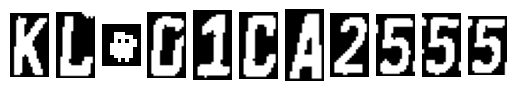

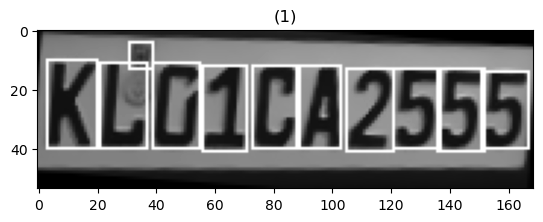

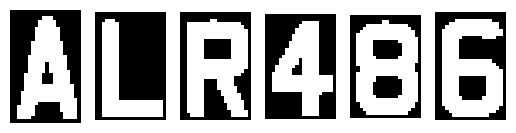

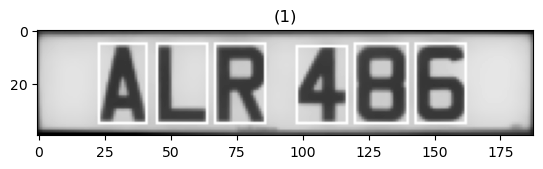

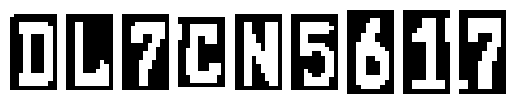

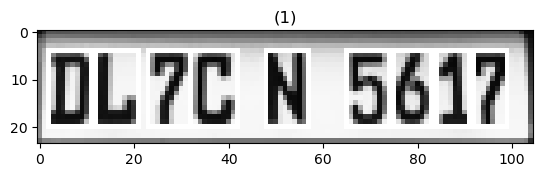

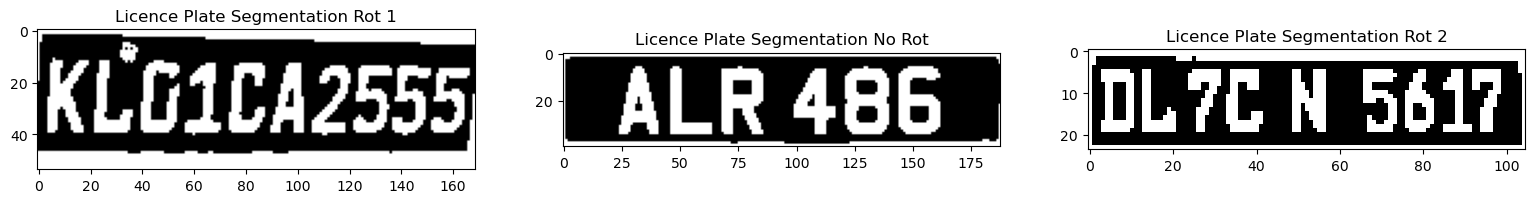

In [436]:
car1_image = cv2.imread('./samples/rotation.png')
car2_image = cv2.imread('./samples/no-rotation.png')
car3_image = cv2.imread('./samples/no-rotation1.png')
cars=[car1_image,car2_image,car3_image]
# show_images(cars, ["Input Image1","Input Image2","Input Image"])

cars_image_cropped = [crop_image(car) for car in cars]
# show_images(cars_image_cropped, ["Car Image Cropped","Car Image Cropped","Car Image Cropped"])

car_image_rotated = [rotate_image(car) for car in cars_image_cropped]
# show_images(car_image_rotated, ["Car Image Rotated","Car Image Not Rotated","Car Image Rotated2"])

licence_plate_segmentation=[segment_Character(car) for car in car_image_rotated]
show_images(licence_plate_segmentation, ["Licence Plate Segmentation Rot 1","Licence Plate Segmentation No Rot","Licence Plate Segmentation Rot 2"])